In [76]:
%pip install lpips

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [172]:
#!g1.1
from torch import nn
from torch.nn import functional as F
from torch.optim import AdamW
import torch
from typing import Iterator
import os
import random
from torchvision import transforms
from PIL import Image
from torchvision import models
from IPython import display
import matplotlib.pyplot as plt
import lpips
import tqdm

In [173]:
#!g1.1
class ImagesDataset(torch.utils.data.IterableDataset):
    CATEGORIES = ["apparel", "artwork", "cars", "dishes", "furniture", "illustrations", "landmark", "meme", "packaged", "storefronts", "toys"]
    TRANSFORM = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    def __init__(self, root_path: str):
        self.root_path = root_path
        self.datasets = [iter(self.get_category_iter(os.path.join(root_path, category))) for category in self.CATEGORIES]
    
    @classmethod
    def get_category_iter(cls, path: str) -> Iterator[str]:
        yield from os.scandir(path)
    
    def __iter__(self):
        while True:
            dataset_index = random.randrange(len(self.datasets))
            try:
                img_path = next(self.datasets[dataset_index]).path
            except StopIteration:
                self.datasets[dataset_index] = iter(self.get_category_iter(os.path.join(self.root_path, self.CATEGORIES[dataset_index])))
            img = Image.open(img_path)
            yield self.TRANSFORM(img)

In [ ]:
#!g1.1
import torch
import torch.nn as nn

def get_configs(arch='resnet50'):

    # True or False means wether to use BottleNeck

    if arch == 'resnet18':
        return [2, 2, 2, 2], False
    elif arch == 'resnet34':
        return [3, 4, 6, 3], False
    elif arch == 'resnet50':
        return [3, 4, 6, 3], True
    elif arch == 'resnet101':
        return [3, 4, 23, 3], True
    elif arch == 'resnet152':
        return [3, 8, 36, 3], True
    else:
        raise ValueError("Undefined model")

class ResNetAutoEncoder(nn.Module):

    def __init__(self, configs, bottleneck):

        super(ResNetAutoEncoder, self).__init__()

        self.encoder = ResNetEncoder(configs=configs,       bottleneck=bottleneck)
        self.decoder = ResNetDecoder(configs=configs[::-1], bottleneck=bottleneck)
    
    def save(self, save_to: str):
        torch.save(self.encoder.state_dict(), os.path.join(save_to, "encoder.pth"))
        torch.save(self.decoder.state_dict(), os.path.join(save_to, "decoder.pth"))

    def forward(self, x):

        x = self.encoder(x)
        
        x = x + torch.normal(-0.5, 0.5, size=x.shape).to("cuda") / (1 << 2)
    
        x = self.decoder(x)

        return x

class ResNet(nn.Module):

    def __init__(self, configs, bottleneck=False, num_classes=1000):
        super(ResNet, self).__init__()

        self.encoder = ResNetEncoder(configs, bottleneck)

        self.avpool = nn.AdaptiveAvgPool2d((1,1))

        if bottleneck:
            self.fc = nn.Linear(in_features=2048, out_features=num_classes)
        else:
            self.fc = nn.Linear(in_features=512, out_features=num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode="fan_in", nonlinearity="relu")
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):

        x = self.encoder(x)

        x = self.avpool(x)

        x = torch.flatten(x, 1)

        x = self.fc(x)

        return x


class ResNetEncoder(nn.Module):

    def __init__(self, configs, bottleneck=False):
        super(ResNetEncoder, self).__init__()

        if len(configs) != 4:
            raise ValueError("Only 4 layers can be configued")

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
        )

        if bottleneck:

            self.conv2 = EncoderBottleneckBlock(in_channels=64,   hidden_channels=64,  up_channels=256,  layers=configs[0], downsample_method="pool")
            self.conv3 = EncoderBottleneckBlock(in_channels=256,  hidden_channels=128, up_channels=512,  layers=configs[1], downsample_method="conv")
            self.conv4 = EncoderBottleneckBlock(in_channels=512,  hidden_channels=256, up_channels=1024, layers=configs[2], downsample_method="conv")
            self.conv5 = EncoderBottleneckBlock(in_channels=1024, hidden_channels=512, up_channels=2048, layers=configs[3], downsample_method="conv")

        else:

            self.conv2 = EncoderResidualBlock(in_channels=64,  hidden_channels=64,  layers=configs[0], downsample_method="pool")
            self.conv3 = EncoderResidualBlock(in_channels=64,  hidden_channels=128, layers=configs[1], downsample_method="conv")
            self.conv4 = EncoderResidualBlock(in_channels=128, hidden_channels=256, layers=configs[2], downsample_method="conv")
            self.conv5 = EncoderResidualBlock(in_channels=256, hidden_channels=512, layers=configs[3], downsample_method="conv")

    def forward(self, x):

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        x = torch.flatten(x, start_dim=1)

        return x

class ResNetDecoder(nn.Module):

    def __init__(self, configs, bottleneck=False):
        super(ResNetDecoder, self).__init__()

        if len(configs) != 4:
            raise ValueError("Only 4 layers can be configued")

        if bottleneck:

            self.conv1 = DecoderBottleneckBlock(in_channels=2048, hidden_channels=512, down_channels=1024, layers=configs[0])
            self.conv2 = DecoderBottleneckBlock(in_channels=1024, hidden_channels=256, down_channels=512,  layers=configs[1])
            self.conv3 = DecoderBottleneckBlock(in_channels=512,  hidden_channels=128, down_channels=256,  layers=configs[2])
            self.conv4 = DecoderBottleneckBlock(in_channels=256,  hidden_channels=64,  down_channels=64,   layers=configs[3])


        else:

            self.conv1 = DecoderResidualBlock(hidden_channels=512, output_channels=256, layers=configs[0])
            self.conv2 = DecoderResidualBlock(hidden_channels=256, output_channels=128, layers=configs[1])
            self.conv3 = DecoderResidualBlock(hidden_channels=128, output_channels=64,  layers=configs[2])
            self.conv4 = DecoderResidualBlock(hidden_channels=64,  output_channels=64,  layers=configs[3])

        self.conv5 = nn.Sequential(
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=7, stride=2, padding=3, output_padding=1, bias=False),
        )

        self.gate = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, 512, 7, 7)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.gate(x)

        return x

class EncoderResidualBlock(nn.Module):

    def __init__(self, in_channels, hidden_channels, layers, downsample_method="conv"):
        super(EncoderResidualBlock, self).__init__()

        if downsample_method == "conv":

            for i in range(layers):

                if i == 0:
                    layer = EncoderResidualLayer(in_channels=in_channels, hidden_channels=hidden_channels, downsample=True)
                else:
                    layer = EncoderResidualLayer(in_channels=hidden_channels, hidden_channels=hidden_channels, downsample=False)
                
                self.add_module('%02d EncoderLayer' % i, layer)
        
        elif downsample_method == "pool":

            maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            self.add_module('00 MaxPooling', maxpool)

            for i in range(layers):

                if i == 0:
                    layer = EncoderResidualLayer(in_channels=in_channels, hidden_channels=hidden_channels, downsample=False)
                else:
                    layer = EncoderResidualLayer(in_channels=hidden_channels, hidden_channels=hidden_channels, downsample=False)
                
                self.add_module('%02d EncoderLayer' % (i+1), layer)
    
    def forward(self, x):

        for name, layer in self.named_children():

            x = layer(x)

        return x

class EncoderBottleneckBlock(nn.Module):

    def __init__(self, in_channels, hidden_channels, up_channels, layers, downsample_method="conv"):
        super(EncoderBottleneckBlock, self).__init__()

        if downsample_method == "conv":

            for i in range(layers):

                if i == 0:
                    layer = EncoderBottleneckLayer(in_channels=in_channels, hidden_channels=hidden_channels, up_channels=up_channels, downsample=True)
                else:
                    layer = EncoderBottleneckLayer(in_channels=up_channels, hidden_channels=hidden_channels, up_channels=up_channels, downsample=False)
                
                self.add_module('%02d EncoderLayer' % i, layer)
        
        elif downsample_method == "pool":

            maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

            self.add_module('00 MaxPooling', maxpool)

            for i in range(layers):

                if i == 0:
                    layer = EncoderBottleneckLayer(in_channels=in_channels, hidden_channels=hidden_channels, up_channels=up_channels, downsample=False)
                else:
                    layer = EncoderBottleneckLayer(in_channels=up_channels, hidden_channels=hidden_channels, up_channels=up_channels, downsample=False)
                
                self.add_module('%02d EncoderLayer' % (i+1), layer)
    
    def forward(self, x):

        for name, layer in self.named_children():

            x = layer(x)

        return x


class DecoderResidualBlock(nn.Module):

    def __init__(self, hidden_channels, output_channels, layers):
        super(DecoderResidualBlock, self).__init__()

        for i in range(layers):

            if i == layers - 1:
                layer = DecoderResidualLayer(hidden_channels=hidden_channels, output_channels=output_channels, upsample=True)
            else:
                layer = DecoderResidualLayer(hidden_channels=hidden_channels, output_channels=hidden_channels, upsample=False)
            
            self.add_module('%02d EncoderLayer' % i, layer)
    
    def forward(self, x):

        for name, layer in self.named_children():

            x = layer(x)

        return x

class DecoderBottleneckBlock(nn.Module):

    def __init__(self, in_channels, hidden_channels, down_channels, layers):
        super(DecoderBottleneckBlock, self).__init__()

        for i in range(layers):

            if i == layers - 1:
                layer = DecoderBottleneckLayer(in_channels=in_channels, hidden_channels=hidden_channels, down_channels=down_channels, upsample=True)
            else:
                layer = DecoderBottleneckLayer(in_channels=in_channels, hidden_channels=hidden_channels, down_channels=in_channels, upsample=False)
            
            self.add_module('%02d EncoderLayer' % i, layer)
    
    
    def forward(self, x):

        for name, layer in self.named_children():

            x = layer(x)

        return x


class EncoderResidualLayer(nn.Module):

    def __init__(self, in_channels, hidden_channels, downsample):
        super(EncoderResidualLayer, self).__init__()

        if downsample:
            self.weight_layer1 = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=3, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(num_features=hidden_channels),
                nn.ReLU(inplace=True),
            )
        else:
            self.weight_layer1 = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(num_features=hidden_channels),
                nn.ReLU(inplace=True),
            )

        self.weight_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=hidden_channels),
        )

        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=1, stride=2, padding=0, bias=False),
                nn.BatchNorm2d(num_features=hidden_channels),
            )
        else:
            self.downsample = None

        self.relu = nn.Sequential(
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):

        identity = x

        x = self.weight_layer1(x)
        x = self.weight_layer2(x)

        if self.downsample is not None:
            identity = self.downsample(identity)

        x = x + identity

        x = self.relu(x)

        return x

class EncoderBottleneckLayer(nn.Module):

    def __init__(self, in_channels, hidden_channels, up_channels, downsample):
        super(EncoderBottleneckLayer, self).__init__()

        if downsample:
            self.weight_layer1 = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=1, stride=2, padding=0, bias=False),
                nn.BatchNorm2d(num_features=hidden_channels),
                nn.ReLU(inplace=True),
            )
        else:
            self.weight_layer1 = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(num_features=hidden_channels),
                nn.ReLU(inplace=True),
            )

        self.weight_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=hidden_channels),
            nn.ReLU(inplace=True),
        )

        self.weight_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_channels, out_channels=up_channels, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=up_channels),
        )

        if downsample:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=up_channels, kernel_size=1, stride=2, padding=0, bias=False),
                nn.BatchNorm2d(num_features=up_channels),
            )
        elif (in_channels != up_channels):
            self.downsample = None
            self.up_scale = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=up_channels, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(num_features=up_channels),
            )
        else:
            self.downsample = None
            self.up_scale = None

        self.relu = nn.Sequential(
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):

        identity = x

        x = self.weight_layer1(x)
        x = self.weight_layer2(x)
        x = self.weight_layer3(x)

        if self.downsample is not None:
            identity = self.downsample(identity)
        elif self.up_scale is not None:
            identity = self.up_scale(identity)

        x = x + identity

        x = self.relu(x)

        return x

class DecoderResidualLayer(nn.Module):

    def __init__(self, hidden_channels, output_channels, upsample):
        super(DecoderResidualLayer, self).__init__()

        self.weight_layer1 = nn.Sequential(
            nn.BatchNorm2d(num_features=hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
        )

        if upsample:
            self.weight_layer2 = nn.Sequential(
                nn.BatchNorm2d(num_features=hidden_channels),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=output_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)                
            )
        else:
            self.weight_layer2 = nn.Sequential(
                nn.BatchNorm2d(num_features=hidden_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=hidden_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1, bias=False),
            )

        if upsample:
            self.upsample = nn.Sequential(
                nn.BatchNorm2d(num_features=hidden_channels),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=output_channels, kernel_size=1, stride=2, output_padding=1, bias=False)   
            )
        else:
            self.upsample = None
    
    def forward(self, x):

        identity = x

        x = self.weight_layer1(x)
        x = self.weight_layer2(x)

        if self.upsample is not None:
            identity = self.upsample(identity)

        x = x + identity

        return x

class DecoderBottleneckLayer(nn.Module):

    def __init__(self, in_channels, hidden_channels, down_channels, upsample):
        super(DecoderBottleneckLayer, self).__init__()

        self.weight_layer1 = nn.Sequential(
            nn.BatchNorm2d(num_features=in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=1, stride=1, padding=0, bias=False),
        )

        self.weight_layer2 = nn.Sequential(
            nn.BatchNorm2d(num_features=hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, stride=1, padding=1, bias=False),
        )

        if upsample:
            self.weight_layer3 = nn.Sequential(
                nn.BatchNorm2d(num_features=hidden_channels),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=down_channels, kernel_size=1, stride=2, output_padding=1, bias=False)
            )
        else:
            self.weight_layer3 = nn.Sequential(
                nn.BatchNorm2d(num_features=hidden_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=hidden_channels, out_channels=down_channels, kernel_size=1, stride=1, padding=0, bias=False)
            )

        if upsample:
            self.upsample = nn.Sequential(
                nn.BatchNorm2d(num_features=in_channels),
                nn.ReLU(inplace=True),
                nn.ConvTranspose2d(in_channels=in_channels, out_channels=down_channels, kernel_size=1, stride=2, output_padding=1, bias=False)
            )
        elif (in_channels != down_channels):
            self.upsample = None
            self.down_scale = nn.Sequential(
                nn.BatchNorm2d(num_features=in_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=in_channels, out_channels=down_channels, kernel_size=1, stride=1, padding=0, bias=False)
            )
        else:
            self.upsample = None
            self.down_scale = None
    
    def forward(self, x):

        identity = x

        x = self.weight_layer1(x)
        x = self.weight_layer2(x)
        x = self.weight_layer3(x)

        if self.upsample is not None:
            identity = self.upsample(identity)
        elif self.down_scale is not None:
            identity = self.down_scale(identity)

        x = x + identity

        return x

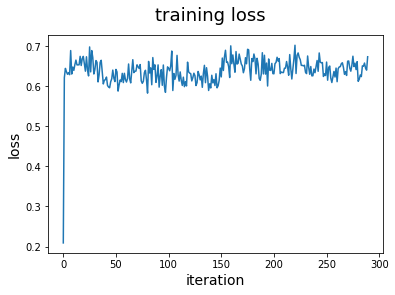

In [ ]:
#!g1.1
STEPS = 10000
SAVE_EVERY = 1000
BATCH_SIZE = 128
LR=0.1
WEIGHT_DECAY=1e-4
MOMENTUM=0.9

torch.autograd.set_detect_anomaly(True)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
model = ResNetAutoEncoder(*get_configs("resnet18")).to(device)

pth = torch.load("caltech256-resnet18.pth")
weights = {key.replace("module.", ""): value for key, value in pth["state_dict"] .items()}
model.load_state_dict(weights)
dataset = ImagesDataset("data")
dataloader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE)
lpips_fn = lpips.LPIPS(net='vgg', lpips=False).to(device)
mse_fn = nn.MSELoss()
optimizer = torch.optim.SGD(
            filter(lambda p: p.requires_grad, model.parameters()),
            LR,
            momentum=MOMENTUM,
            weight_decay=WEIGHT_DECAY)
optimizer.load_state_dict(pth["optimizer"])

loss_history = []

step = 0
model.train()

for batch in dataloader:
    batch = batch.to(device)

    restored = model(batch)

#     f, axarr = plt.subplots(2,1) 
#     axarr[0].imshow(batch[0].permute(1, 2, 0).to("cpu"))
#     axarr[1].imshow(restored[0].permute(1, 2, 0).detach().to("cpu"))
#     plt.show()

    try:
        lpips_loss = lpips_fn(restored, batch).mean()
    except:
        lpips_loss = 0
    mse_loss = mse_fn(restored, batch)

    loss = lpips_loss / 14 + mse_loss / 0.06
    loss_history.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    f = plt.figure()
    plt.plot(loss_history)
    f.suptitle('training loss', fontsize=18)
    plt.xlabel('iteration', fontsize=14)
    plt.ylabel('loss', fontsize=14)
    plt.show()
    
    display.clear_output(wait=True)

    if step % SAVE_EVERY == 0:
        dirname = f"b2-weights-{step}"
        os.makedirs(dirname, exist_ok=True)
        model.save(dirname)

    step += 1
    if step >= STEPS:
        break
pbar.close()

In [ ]:
#!g1.1


In [ ]:
#!g1.1
